# Libraries



Import Primary Modules:

In [1]:
import random 
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline 

from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
import folium 
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize 
from urllib.request import urlopen
import json
print('Libraries imported.')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries imported.


# Foursquare Parameters

Setting data to use Foursquare API

In [0]:
CLIENT_ID = 'G3GR4LL0TKXIX1VVLLFCTMUONRZVR3UHNGO2U11SJXSQQ3WT' 
CLIENT_SECRET = 'KIBQJ0LETUPWK3KPZP0QSLONURSIZ33303QGJ2NN10K005WY' 
VERSION = '20180605'

LIMIT = 500 
RADIUS = 8000 

# Analysis and clean the dataset

### Load CSV

In [0]:
departamentos = pd.read_csv('/content/drive/My Drive/departamentos.csv')

## Get data only from Buenos Aires y CABA

In [0]:
mask1 = departamentos['provincia_nombre'] == "Buenos Aires"
mask2 = departamentos['provincia_nombre'] == "Ciudad Autónoma de Buenos Aires"

In [0]:
departamentos_bsas = departamentos[mask1 | mask2]

## BS AS Map



In [11]:
address = 'Buenos Aires'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Buenos Aires are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Buenos Aires are -34.6075682, -58.4370894.


In [12]:
# create map of New York using latitude and longitude values
map_bsas = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(departamentos_bsas['centroide_lat'], departamentos_bsas['centroide_lon'], departamentos_bsas['nombre_completo'], departamentos_bsas['nombre']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bsas)  
    
map_bsas

## Studing each Neighborhood

Function to search values per Neighborhood

In [0]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, RADIUS, LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

In [0]:
bsas_venues = getNearbyVenues(names=departamentos_bsas['nombre'],
                                   latitudes=departamentos_bsas['centroide_lat'],
                                   longitudes=departamentos_bsas['centroide_lon'])


Save file to not use Foursquare all time

In [0]:
#bsas_venues.to_csv(r'/content/drive/My Drive/L300R8000.csv', index = False)
#bsas_venues = pd.read_csv('/content/drive/My Drive/four.csv')

## Onehot encoder categories

In [18]:
# one hot encoding
bsas_onehot = pd.get_dummies(bsas_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bsas_onehot['Neighborhood'] = bsas_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bsas_onehot.columns[-1]] + list(bsas_onehot.columns[:-1])
bsas_onehot = bsas_onehot[fixed_columns]

bsas_onehot.head(10)

Zoo  Accessories Store  Airport  ...  Wine Shop  Women's Store  Yoga Studio
0    0                  0        0  ...          0              0            0
1    0                  0        0  ...          0              0            0
2    0                  0        0  ...          0              0            0
3    0                  0        0  ...          0              0            0
4    0                  0        0  ...          0              0            0
5    0                  0        0  ...          0              0            0
6    0                  0        0  ...          0              0            0
7    0                  0        0  ...          0              0            0
8    0                  0        0  ...          0              0            0
9    0                  0        0  ...          0              0            0

[10 rows x 237 columns]

## Group per Neighborhood and get Total

In [19]:
bsas_grouped = bsas_onehot.groupby('Neighborhood').mean().reset_index()
bsas_grouped

Neighborhood  Zoo  ...  Women's Store  Yoga Studio
0         9 de Julio  0.0  ...            0.0          0.0
1            Alberti  0.0  ...            0.0          0.0
2    Almirante Brown  0.0  ...            0.0          0.0
3          Arrecifes  0.0  ...            0.0          0.0
4         Avellaneda  0.0  ...            0.0          0.0
..               ...  ...  ...            ...          ...
106       Tres Lomas  0.0  ...            0.0          0.0
107  Tres de Febrero  0.0  ...            0.0          0.0
108    Vicente López  0.0  ...            0.0          0.0
109     Villa Gesell  0.0  ...            0.0          0.0
110           Zárate  0.0  ...            0.0          0.0

[111 rows x 237 columns]

Calculating *Total*

Set different goals

In [0]:
categorias_objetivo = [ 'Zoo',
 'Accessories Store',
 'American Restaurant',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Garage',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bar',
 'Beer Bar',
 'Beer Garden',
 'Bookstore',
 'Breakfast Spot',
 'Buffet',
 'Bus Station',
 'Cafeteria',
 'Café',
 'Candy Store',
 'Casino',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'City',
 'Clothing Store',
 'Cocktail Bar',
 'College Gym',
 'Cosmetics Shop',
 'Dance Studio',
 'Deli / Bodega',
 'Department Store',
 'Dessert Shop',
 "Doctor's Office",
 'Farm',
 'Farmers Market',
 'Fast Food Restaurant',
 'Fish Market',
 'Food & Drink Shop',
 'Food Truck',
 'Fruit & Vegetable Store',
 'Furniture / Home Store',
 'Gas Station',
 'General Entertainment',
 'German Restaurant',
 'Grocery Store',
 'Gym',
 'Gym / Fitness Center',
 'Gym Pool',
 'Gymnastics Gym',
 'Harbor / Marina',
 'Hardware Store',
 'Ice Cream Shop',
 'Indian Restaurant',
 'Irish Pub',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Jazz Club',
 'Korean Restaurant',
 'Latin American Restaurant',
 'Market',
 'Mediterranean Restaurant',
 "Men's Store",
 'Mexican Restaurant',
 'Mobile Phone Shop',
 'Motorcycle Shop',
 'Movie Theater',
 'Museum',
 'Nightclub',
 'Park',
 'Pet Store',
 'Pharmacy',
 'Pool',
 'Portuguese Restaurant',
 'Pub',
 'Restaurant',
 'Rock Club',
 'Theme Restaurant',
 'Toll Booth',
 'Tourist Information Center',
 'Toy / Game Store',
 'Track',
 'Train Station',
 'Travel Lounge',
 'Tunnel',
 'University',
 'Vacation Rental',
 'Vegetarian / Vegan Restaurant',
 'Video Game Store',
 'Video Store',
 'Wine Bar',
 'Wine Shop',
 "Women's Store",
 'Yoga Studio']

In [0]:
bsas_grouped['total'] = bsas_grouped[categorias_objetivo].sum(axis=1)
#sumar todo:
#bsas_grouped['total'] = bsas_grouped.sum(axis=1)
bsas_grouped['Neighborhood'] = bsas_grouped['Neighborhood'].str.upper()

In [0]:
with urlopen('https://raw.githubusercontent.com/mgaitan/departamentos_argentina/master/departamentos-argentina.json') as response:
    dptosgeo = json.load(response)

output_dict = [x for x in dptosgeo['features'] if x['properties']['provincia'] == "BUENOS AIRES"]


bsasmap = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')

In [0]:
dptosgeo = {'features': output_dict}

In [0]:
datos = []
for feature in dptosgeo['features']:
    item = {
        'Neighborhood': feature['properties']['departamento'],
    }
    datos.append(item)

In [0]:
datos = pd.DataFrame(datos)


In [0]:
datos = datos.join(bsas_grouped.set_index('Neighborhood'), on='Neighborhood')

In [0]:
datos = datos.fillna(value=0)

In [29]:
bsasmap = folium.Map(location=[-36.612415, -59.872884], zoom_start=6, tiles='Mapbox Bright')
folium.Choropleth(
    geo_data=dptosgeo,
    data=datos,
    columns=['Neighborhood', 'total'],
    key_on='feature.properties.departamento',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Total'
).add_to(bsasmap)
# folium.LayerControl().add_to(bsasmap)
bsasmap

## Lisitng top venue per Neighborhood

In [31]:
num_top_venues = 5
#Note: only first 4 for faster
for hood in bsas_grouped['Neighborhood'][0:4]:
    print("----"+hood+"----")
    temp = bsas_grouped[bsas_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----9 DE JULIO----
                    venue  freq
0                   total   0.5
1        Airport Terminal   0.5
2  Argentinian Restaurant   0.5
3             Pizza Place   0.0
4         Other Nightlife   0.0


----ALBERTI----
             venue  freq
0            total  1.00
1              Bar  0.33
2   Breakfast Spot  0.33
3             Park  0.33
4  Other Nightlife  0.00


----ALMIRANTE BROWN----
            venue  freq
0           total  0.65
1  Ice Cream Shop  0.08
2            Café  0.06
3          Bakery  0.05
4     Pizza Place  0.05


----ARRECIFES----
                    venue  freq
0                   total  0.75
1  Argentinian Restaurant  0.25
2          Ice Cream Shop  0.12
3     Sporting Goods Shop  0.12
4                   Hotel  0.12




In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bsas_grouped['Neighborhood']

for ind in np.arange(bsas_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bsas_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood  ... 10th Most Common Venue
0       9 DE JULIO  ...             Food Truck
1          ALBERTI  ...                 Forest
2  ALMIRANTE BROWN  ...                    Bar
3        ARRECIFES  ...        Doctor's Office
4       AVELLANEDA  ...         Clothing Store

[5 rows x 11 columns]

## Cluster **Neighborhoods**

In [34]:
# set number of clusters
kclusters = 100

bsas_grouped_clustering = bsas_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bsas_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([39, 30, 91, 51, 90,  3,  5, 36, 75, 69], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [0]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [37]:
neighborhoods_venues_sorted.head()

Cluster Labels     Neighborhood  ... 9th Most Common Venue 10th Most Common Venue
0              39       9 DE JULIO  ...                Forest             Food Truck
1              30          ALBERTI  ...     French Restaurant                 Forest
2              91  ALMIRANTE BROWN  ...           Snack Place                    Bar
3              51        ARRECIFES  ...                 Field        Doctor's Office
4              90       AVELLANEDA  ...        Soccer Stadium         Clothing Store

[5 rows x 12 columns]

In [0]:

bsas_merged = departamentos_bsas

bsas_merged = bsas_merged.rename(columns={"nombre": "Neighborhood"})
bsas_merged['Neighborhood'] = bsas_merged['Neighborhood'].str.upper()
bsas_merged


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bsas_merged = bsas_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [0]:
bsas_merged = bsas_merged.dropna(axis='rows')

In [0]:
bsas_merged['Cluster Labels']= bsas_merged['Cluster Labels'].astype(int)

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bsas_merged['centroide_lat'], bsas_merged['centroide_lon'], bsas_merged['Neighborhood'], bsas_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analysis of a particular neighborhood

Neighborhood selected: MORON

In [0]:
moron = departamentos_bsas[departamentos_bsas['nombre'] == 'Morón']

In [0]:
centro_moron_lat = moron.centroide_lat
centro_moron_lon = moron.centroide_lon

In [0]:
with urlopen('https://raw.githubusercontent.com/mgaitan/departamentos_argentina/master/departamentos-argentina.json') as response:
    dptosgeo = json.load(response)

In [0]:
for x in dptosgeo['features'][0:100]:
  if(x['properties']['departamento'] in "MORON"):
    geo_moron = x

In [0]:
geo_moron = {'features': [geo_moron]}

In [48]:
moron

categoria  centroide_lat  ...  provincia_interseccion provincia_nombre
166   Partido     -34.649141  ...                0.000176     Buenos Aires

[1 rows x 10 columns]

In [49]:
moron['nombre'] = "MORON"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
bsasmap = folium.Map(location=[34.6037,  58.3816], zoom_start=2, tiles='Mapbox Bright')
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
folium.Choropleth(
    geo_data=dptosgeo,
    data=moron,
    columns=['nombre', 'id'],
    key_on='feature.properties.departamento',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Total'
).add_to(bsasmap)
# folium.LayerControl().add_to(bsasmap)


In [0]:
limites_moron = geo_moron['features'][0]['geometry']['coordinates'][0]

### Neighborhood Area

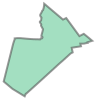

In [54]:
from shapely.geometry import Point, LineString, Polygon
polyMoron = Polygon(limites_moron)
polyMoron

In [0]:
def generate_random(number, polygon):
    list_of_points = []
    listCoor = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    for p in list_of_points:
      listCoor.append([p.x,p.y])
    return listCoor

In [0]:
points_randums_moron = generate_random(20,polyMoron)

In [59]:
points_randums_moron

[[-58.644133256928676, -34.70161784503433],
 [-58.58565118719524, -34.65144919611769],
 [-58.622409645932436, -34.66148724763476],
 [-58.6061427012344, -34.61216034205749],
 [-58.651639466247126, -34.697350981056026],
 [-58.63816099195342, -34.6660907820175],
 [-58.60021328661932, -34.60398277641128],
 [-58.618644641051475, -34.60494617896647],
 [-58.638897001043134, -34.69896066820997],
 [-58.61991355298342, -34.674632416274015],
 [-58.58483140494868, -34.64699478804921],
 [-58.64470004599482, -34.641274274650115],
 [-58.64572443042102, -34.652332118583466],
 [-58.65618983405806, -34.67353456553866],
 [-58.64981461646019, -34.675678809189094],
 [-58.59451717182106, -34.65794573429657],
 [-58.65886195041445, -34.671997864967935],
 [-58.65441280242484, -34.645079133996965],
 [-58.63120217242051, -34.682032231943566],
 [-58.596667114709625, -34.61297322064644]]

## Studing each points

In [0]:
def getNearbyVenuesMoron(latitudes, longitudes):
    
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, RADIUS, LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            'Moron',
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

In [0]:
columns = ['lat','long']
df_ = pd.DataFrame(columns=columns)

In [0]:
for l in points_randums_moron:
  p = {'lat':l[1],'long':l[0]}
  df_ = df_.append(p, ignore_index=True)

In [64]:
df_

lat       long
0  -34.701618 -58.644133
1  -34.651449 -58.585651
2  -34.661487 -58.622410
3  -34.612160 -58.606143
4  -34.697351 -58.651639
5  -34.666091 -58.638161
6  -34.603983 -58.600213
7  -34.604946 -58.618645
8  -34.698961 -58.638897
9  -34.674632 -58.619914
10 -34.646995 -58.584831
11 -34.641274 -58.644700
12 -34.652332 -58.645724
13 -34.673535 -58.656190
14 -34.675679 -58.649815
15 -34.657946 -58.594517
16 -34.671998 -58.658862
17 -34.645079 -58.654413
18 -34.682032 -58.631202
19 -34.612973 -58.596667

In [0]:
LIMIT = 20
RADIUS = 2000

bsas_venues_moron = getNearbyVenuesMoron(latitudes=df_['lat'],
                                   longitudes=df_['long'])


## Generating dataframe

In [0]:
bsas_venues_moron = bsas_venues_moron.reset_index()

In [0]:
bsas_venues_moron['Neighborhood Longitude'].unique()

array([-58.59925488, -58.63601121, -58.65405284, -58.58564243,
       -58.63231613, -58.60563217, -58.63929447, -58.6145792 ,
       -58.60078802, -58.64510594, -58.64427757, -58.62988103,
       -58.59542131, -58.571298  , -58.62287833, -58.61049267,
       -58.57987849, -58.6128732 , -58.6003583 , -58.65708237,
       -58.66405064, -58.59587442, -58.63707969, -58.59685197,
       -58.63000088, -58.60533056, -58.65265522, -58.60774462,
       -58.63259515, -58.63913037, -58.56607181, -58.58474042,
       -58.63835878, -58.64719906, -58.62922017, -58.65862651,
       -58.61215203, -58.64576844, -58.61366627, -58.56171596])

In [0]:
bsas_venues_moron['latlon'] = list(zip(bsas_venues_moron['Neighborhood Latitude'], bsas_venues_moron['Neighborhood Longitude']))

In [67]:
bsas_venues_moron.head()

Neighborhood  ...                                     latlon
0        Moron  ...  (-34.70161784503433, -58.644133256928676)
1        Moron  ...  (-34.70161784503433, -58.644133256928676)
2        Moron  ...  (-34.70161784503433, -58.644133256928676)
3        Moron  ...  (-34.70161784503433, -58.644133256928676)
4        Moron  ...   (-34.65144919611769, -58.58565118719524)

[5 rows x 8 columns]

In [68]:
# one hot encoding
bsas_moron_onehot = pd.get_dummies(bsas_venues_moron[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bsas_moron_onehot['latlon'] = bsas_venues_moron['latlon'] 

# move neighborhood column to the first column
fixed_columns = [bsas_moron_onehot.columns[-1]] + list(bsas_moron_onehot.columns[:-1])
bsas_moron_onehot = bsas_moron_onehot[fixed_columns]

bsas_moron_onehot.head(10)

latlon  ...  Train Station
0  (-34.70161784503433, -58.644133256928676)  ...              0
1  (-34.70161784503433, -58.644133256928676)  ...              0
2  (-34.70161784503433, -58.644133256928676)  ...              0
3  (-34.70161784503433, -58.644133256928676)  ...              0
4   (-34.65144919611769, -58.58565118719524)  ...              0
5   (-34.65144919611769, -58.58565118719524)  ...              0
6   (-34.65144919611769, -58.58565118719524)  ...              0
7   (-34.65144919611769, -58.58565118719524)  ...              0
8   (-34.65144919611769, -58.58565118719524)  ...              0
9   (-34.65144919611769, -58.58565118719524)  ...              0

[10 rows x 56 columns]

In [0]:
bsas_moron_grouped = bsas_moron_onehot.groupby('latlon').mean().reset_index()

Index(['latlon', 'Accessories Store', 'Airport Service', 'American Restaurant',
       'Argentinian Restaurant', 'Athletics & Sports', 'BBQ Joint', 'Bakery',
       'Bar', 'Beer Garden', 'Bistro', 'Bowling Alley', 'Brewery',
       'Burger Joint', 'Bus Station', 'Business Service', 'Café', 'Casino',
       'Coffee Shop', 'Concert Hall', 'Construction & Landscaping',
       'Convenience Store', 'Creperie', 'Deli / Bodega', 'Department Store',
       'Diner', 'Electronics Store', 'Falafel Restaurant', 'Farmers Market',
       'Fast Food Restaurant', 'Gastropub', 'Golf Course', 'Grocery Store',
       'Gym', 'Gym / Fitness Center', 'Hardware Store', 'Hockey Field',
       'Ice Cream Shop', 'Indie Movie Theater', 'Irish Pub',
       'Japanese Restaurant', 'Kids Store', 'Mexican Restaurant',
       'Military Base', 'Movie Theater', 'Multiplex', 'Museum', 'Music Venue',
       'Nightclub', 'Pastry Shop', 'Perfume Shop', 'Pharmacy', 'Pizza Place',
       'Plaza', 'Pub', 'Restaurant', 'Sandwic

In [0]:
categorias_objetivo=['Accessories Store',
       'Argentinian Restaurant',  'Athletics & Sports',
        'Bakery', 'Bar',  'Brewery',
        'Burger Joint', 'Bus Station', 'Café',
       'Convenience Store' , 'Creperie', 'Deli / Bodega', 'Gym',
       'Ice Cream Shop', 'Indie Movie Theater', 
        'Mexican Restaurant', 'Military Base',
       'Pharmacy', 'Pizza Place', 'Plaza', 'Pub',
       'Restaurant', 'Sandwich Place', 
       'Shopping Mall', 'Soccer Field', 
       'Supermarket', 'Sushi Restaurant', 'Tea Room',
       'Train Station']

In [0]:
bsas_moron_grouped['total'] = bsas_moron_grouped[categorias_objetivo].sum(axis=1)

In [0]:
bsas_moron_grouped[['lat','long']] = bsas_moron_grouped['latlon'].apply(pd.Series)

In [0]:
latitude = -34.700821	
longitude = -58.641155
moron_map = folium.Map(location=[latitude, longitude], zoom_start=12)


## Plotting map

In [79]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, radius in zip(bsas_moron_grouped.lat, bsas_moron_grouped.long, bsas_moron_grouped.total):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=radius*100, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
moron_map.add_child(incidents)